## Enhancing OpenStreetMaps through elevation binding

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
import requests, fiona
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import rasterio as rio
import rioxarray as rxr
from rasterio.merge import merge
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

C:\Users\Sidrcs\AppData\Local\Temp\ipykernel_14480\3505921828.py:14: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(log_console=True, use_cache=True)


'1.6.0'

In [2]:
ox.settings.log_console=True
ox.settings.use_cache=True

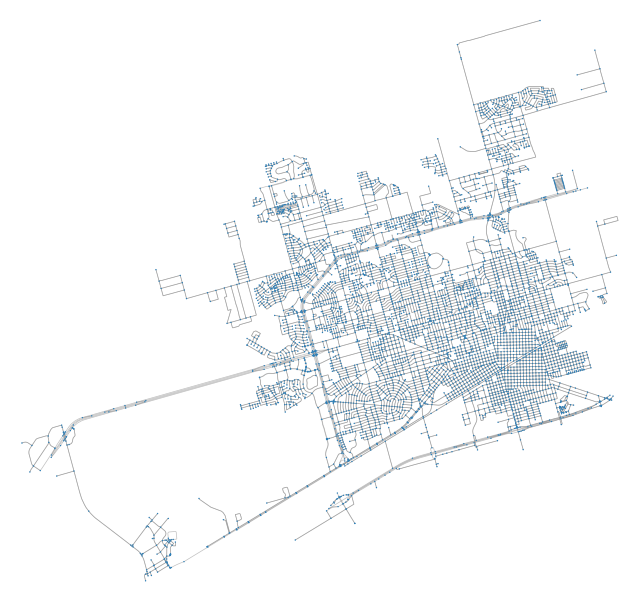

C:\Users\Sidrcs\AppData\Local\Temp\ipykernel_12040\908502189.py:11: UserWarning: The `save_graph_shapefile` function is deprecated and will be removed in a future release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis.
  ox.save_graph_shapefile(G, f"{place.split(',')[0]}")
C:\Users\Sidrcs\anaconda3\envs\ox\Lib\site-packages\osmnx\io.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


In [3]:
# Define place in the following order: 'City, State, Country'
place = 'Midland, Midland County, Texas, USA'
# Load the graph based on 'drive' network
G = ox.graph_from_place(place, network_type='drive')
# Plot the graph based on place
fig, ax = ox.plot_graph(G, bgcolor = 'white', edge_color = 'gray', node_color = '#2c7fb8',
                        edge_linewidth=0.5, edge_alpha = 0.5, node_size = 1)


# Saves nodes, edges as shapefiles into the folder: Midland
ox.save_graph_shapefile(G, f"{place.split(',')[0]}")

In [4]:
# Saves nodes, edges as shapefiles into the folder: Midland
ox.save_graph_geopackage(G, f"{place.split(',')[0]}")

Text(0.5, 1.0, 'Edges of Midland City, Texas')

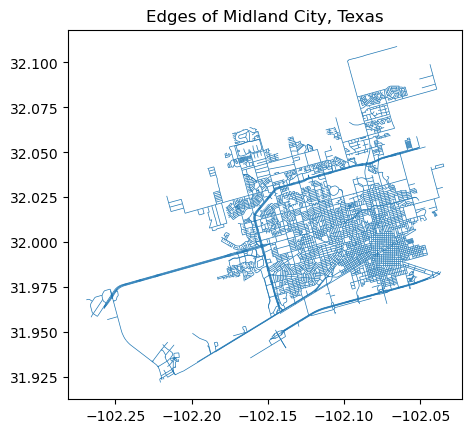

In [7]:
midland_edge = gpd.read_file('Midland/edges.shp')
midland_edge.plot(linewidth=0.5)
plt.title('Edges of Midland City, Texas')

In [9]:
midland_edge.head(1)

,u,v,key,osmid,name,highway,oneway,reversed,length,from,to,lanes,ref,maxspeed,bridge,access,junction,geometry
0,227119561,227119675,0,21117153,Doral Court,residential,0,True,134.38,227119675,227119561,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-102.09898 32.05112, -102.09796 32..."


### Function to merge multiple rasters

Text(0.5, 1.0, 'Nodes of Midland City, Texas')

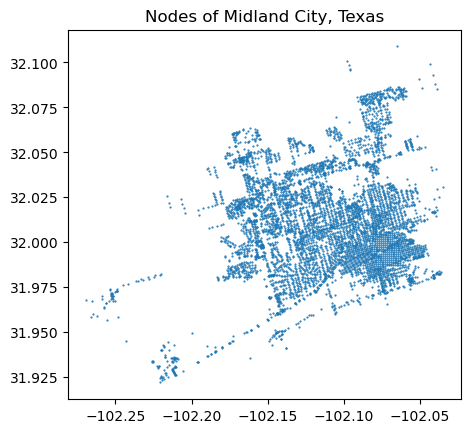

In [8]:
midland_nodes = gpd.read_file('Midland/nodes.shp')
midland_nodes.plot(markersize=0.3)
plt.title('Nodes of Midland City, Texas')

In [5]:
def merge_rasters(input_paths, output_path):
    # Open each input raster
    src_files_to_mosaic = [rio.open(path) for path in input_paths]
    # Merge rasters
    #mosaic, out_trans = merge(src_files_to_mosaic, resampling=Resampling.max)
    merged_data, merged_transform = merge(src_files_to_mosaic)
    # Update metadata for the output raster
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({"driver": "GTiff", 
                     "height": merged_data.shape[1], 
                     "width": merged_data.shape[2], 
                     "transform": merged_transform})
    # Write the merged raster to the output file
    with rio.open(output_path, "w", **out_meta) as dest:
        dest.write(merged_data)
    print(f"Mosaic created at {output_path}")

In [26]:
import os
input_paths = [os.path.join('Midland_DEM',file) for file in os.listdir('Midland_DEM')]
output_path = 'Midland_DEM/Merged_DEM_Midland.tif'
merge_rasters(input_paths, output_path)

Mosaic created at Midland_DEM/Merged_DEM_Midland.tif


In [31]:
# To find CRS of merged DEM raster
with rio.open('Midland_DEM/Merged_DEM_Midland.tif') as dst:
    print(dst.crs)

EPSG:4269


### Function to reproject rasters

In [6]:
def reproj_raster(input_path, epsg_str, output_path):
    raster = rxr.open_rasterio(input_path)
    reproj_raster = raster.rio.reproject(epsg_str)
    reproj_raster.rio.to_raster(output_path)
    print(f'Reproject raster created at {output_path}')

In [34]:
# Reproject merged DEM raster to EPSG:3857 using rioxarray
dem = rxr.open_rasterio('Midland_DEM/Merged_DEM_Midland.tif')
reproj_dem = dem.rio.reproject('EPSG:3857')
reproj_dem.rio.to_raster('Midland_DEM/Merged_DEM_Midland_Reproj.tif')

In [37]:
# Raster resolution of 1-arc second after reprojectin to EPSG:3857
with rxr.open_rasterio('Midland_DEM/Merged_DEM_Midland_Reproj.tif') as dst:
    print(dst.rio.resolution())

(35.42384839891149, -35.423848398911254)


In [38]:
input_paths = [os.path.join('Midland_DEM',file) for file in os.listdir('Midland_DEM') if '13' in file]
output_path = 'Midland_DEM/Merged_DEM_Midland_13.tif'
merge_rasters(input_paths, output_path)

Mosaic created at Midland_DEM/Merged_DEM_Midland_13.tif


In [41]:
reproj_raster('Midland_DEM/Merged_DEM_Midland_13.tif', 'EPSG:3857', 'Midland_DEM/Merged_DEM_Midland_13_Reproj.tif')

Reproject raster created at Midland_DEM/Merged_DEM_Midland_13_Reproj.tif


In [42]:
input_paths = [os.path.join('1m_Midland_DEM',file) for file in os.listdir('1m_Midland_DEM')]
output_path = '1m_Midland_DEM/Merged_DEM_Midland_1m.tif'
merge_rasters(input_paths, output_path)

MemoryError: Unable to allocate 64.8 GiB for an array with shape (1, 30012, 580012) and data type float32

In [71]:
midland_nodes.head(1)

,osmid,y,x,street_cou,highway,ref,geometry,elev_13_arc,elev_1_arc,elev_diff
0,227119561,32.051585,-102.097694,3,NaN,NaN,POINT (-11365463.307 3770083.866),852.849976,852.900024,0.050049


In [10]:
midland_nodes = midland_nodes.to_crs(3857)

In [11]:
for row in midland_nodes.itertuples():
    osmid = row.osmid
    lon, lat = row.geometry.x, row.geometry.y

    arc_1_dem = rio.open('Midland_DEM/Merged_DEM_Midland_Reproj.tif')
    row, col = arc_1_dem.index(lon,lat)
    arc_1_dem_data = arc_1_dem.read(1)
    print(f'OSM Node ID: {osmid} Elevation: {round(arc_1_dem_data[row, col],2)} meters for 1-arc second DEM')
    break

OSM Node ID: 227119561 Elevation: 852.9000244140625 meters for 1-arc second DEM


In [52]:
for row in midland_nodes.itertuples():
    osmid = row.osmid
    lon, lat = row.geometry.x, row.geometry.y

    arc_1_dem = rio.open('Midland_DEM/Merged_DEM_Midland_13_Reproj.tif')
    row, col = arc_1_dem.index(lon,lat)
    arc_1_dem_data = arc_1_dem.read(1)
    elevation = arc_1_dem_data[row, col]
    print(f'OSM Node ID: {osmid} Elevation: {elevation} meters for 1/3-arc second DEM')
    print(round(elevation,2))
    break

OSM Node ID: 227119561 Elevation: 852.8538818359375 meters for 1/3-arc second DEM
852.85


In [17]:
arc_13_dem = rio.open('Midland_DEM/Merged_DEM_Midland_13_Reproj.tif')
arc_13_dem_data = arc_13_dem.read(1)
midland_nodes['elev_13_arc'] = None
for index,row in midland_nodes.iterrows():
    osmid = row['osmid']
    lon, lat = row['geometry'].x, row['geometry'].y
    row, col = arc_13_dem.index(lon,lat)
    elevation = arc_13_dem_data[row, col]
    midland_nodes.at[index, 'elev_13_arc'] = round(elevation,2)
arc_13_dem = None

In [63]:
midland_nodes.head(1)

,osmid,y,x,street_cou,highway,ref,geometry,elev_13_arc,elev_1_arc
0,227119561,32.051585,-102.097694,3,NaN,NaN,POINT (-11365463.307 3770083.866),852.849976,852.900024


In [16]:
arc_1_dem = rio.open('Midland_DEM/Merged_DEM_Midland_Reproj.tif')
arc_1_dem_data = arc_1_dem.read(1)
midland_nodes['elev_1_arc'] = None
for index,row in midland_nodes.iterrows():
    osmid = row['osmid']
    lon, lat = row['geometry'].x, row['geometry'].y
    row, col = arc_1_dem.index(lon,lat)
    elevation = arc_1_dem_data[row, col]
    midland_nodes.at[index, 'elev_1_arc'] = round(elevation,2)
arc_1_dem = None

### Bind Elevation to Nodes

In [12]:
def bind_elevation_to_nodes(node_shapefile, dem_raster, col_name):
    node_gdf = gpd.read_file(node_shapefile)
    node_gdf = node_gdf.to_crs(3857)
    dem = rio.open(dem_raster)
    dem_data = dem.read(1)
    node_gdf[col_name] = None
    if node_gdf.crs.to_epsg() == dem.crs.to_epsg():
        for index, row in node_gdf.iterrows():
            osmid = row['osmid']
            lon, lat = row['geometry'].x, row['geometry'].y
            row, col = dem.index(lon,lat)
            elevation = dem_data[row,col]
            node_gdf.at[index, col_name] = elevation
    else:
        print(f"Raster CRS: {dem.crs.to_epsg()} does not match. Reproject raster using reproj_raster function")
    dem = None
    return node_gdf

In [62]:
midland_nodes.head(1)

,osmid,y,x,street_cou,highway,ref,geometry,elev_13_arc,elev_1_arc
0,227119561,32.051585,-102.097694,3,NaN,NaN,POINT (-11365463.307 3770083.866),852.849976,852.900024


In [18]:
def elev_diff(x):
    return (x['elev_1_arc'] - x['elev_13_arc'])
midland_nodes['elev_diff'] = midland_nodes.apply(lambda x: elev_diff(x), axis = 1)
midland_nodes.head(1)

,osmid,y,x,street_cou,highway,ref,geometry,elev_1_arc,elev_13_arc,elev_diff
0,227119561,32.051585,-102.097694,3,NaN,NaN,POINT (-11365463.307 3770083.866),852.900024,852.849976,0.050049


In [68]:
midland_edge.head(1)

,u,v,key,osmid,name,highway,oneway,reversed,length,from,to,lanes,ref,maxspeed,bridge,access,junction,geometry
0,227119561,227119675,0,21117153,Doral Court,residential,0,True,134.38,227119675,227119561,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-102.09898 32.05112, -102.09796 32..."


In [100]:
merged_gdf = None

In [101]:
# Perform a join operation on the 'osmid' column
merged_gdf = midland_edge.merge(midland_nodes, left_on='from', right_on='osmid', how='left')

# Create two new columns 'from_elev' and 'to_elev' in midland_edge
merged_gdf['from_elev'] = merged_gdf['elev_1_arc']  # Assuming 'elev_1_arc' is the elevation column in midland_nodes

In [102]:
merged_gdf.head(1)

,u,v,key,osmid_x,name,highway_x,oneway,reversed,length,from,...,y,x,street_cou,highway_y,ref_y,geometry_y,elev_1_arc,elev_13_arc,elev_diff,from_elev
0,227119561,227119675,0,21117153,Doral Court,residential,0,True,134.38,227119675,...,32.051125,-102.098976,1,turning_circle,NaN,POINT (-11365606.019 3770023.450),852.630005,852.469971,0.160034,852.630005


In [116]:
col_list = list(merged_gdf.columns.values)

In [117]:
merged_gdf.columns.values

array(['u', 'v', 'key', 'osmid_x', 'name', 'highway_x', 'oneway',
       'reversed', 'length', 'from', 'to', 'lanes', 'ref_x', 'maxspeed',
       'bridge', 'access', 'junction', 'geometry_x', 'y_x', 'x_x',
       'street_cou_x', 'from_elev', 'osmid_y', 'y_y', 'x_y',
       'street_cou_y', 'highway_y', 'ref_y', 'geometry_y', 'elev_1_arc',
       'elev_13_arc', 'elev_diff', 'to_elev'], dtype=object)

In [118]:
col = [item for item in col_list if item.endswith("_y")]
col

['osmid_y', 'y_y', 'x_y', 'street_cou_y', 'highway_y', 'ref_y', 'geometry_y']

In [119]:
col_elev = [item for item in col_list if item.startswith("elev")]
col_elev

['elev_1_arc', 'elev_13_arc', 'elev_diff']

In [120]:
merged_gdf = merged_gdf.drop(labels = col, axis = 1)
merged_gdf = merged_gdf.drop(labels = col_elev, axis = 1)

In [121]:
rename_dict = {}
for col in col_list:
    if col.endswith("_x"):
        rename_col = col.split("_")[0]
        rename_dict[col] = rename_col

In [122]:
rename_dict

{'osmid_x': 'osmid',
 'highway_x': 'highway',
 'ref_x': 'ref',
 'geometry_x': 'geometry',
 'y_x': 'y',
 'x_x': 'x',
 'street_cou_x': 'street'}

In [123]:
merged_gdf = merged_gdf.rename(columns = rename_dict)

In [124]:
merged_gdf.columns.values

array(['u', 'v', 'key', 'osmid', 'name', 'highway', 'oneway', 'reversed',
       'length', 'from', 'to', 'lanes', 'ref', 'maxspeed', 'bridge',
       'access', 'junction', 'geometry', 'y', 'x', 'street', 'from_elev',
       'to_elev'], dtype=object)

In [113]:
# Perform a join operation on the 'osmid' column
merged_gdf = merged_gdf.merge(midland_nodes, left_on='to', right_on='osmid', how='left')

merged_gdf['to_elev'] = merged_gdf['elev_1_arc']  # Assuming 'elev_1_arc' is the elevation column in midland_nodes

In [125]:
merged_gdf.columns.values

array(['u', 'v', 'key', 'osmid', 'name', 'highway', 'oneway', 'reversed',
       'length', 'from', 'to', 'lanes', 'ref', 'maxspeed', 'bridge',
       'access', 'junction', 'geometry', 'y', 'x', 'street', 'from_elev',
       'to_elev'], dtype=object)

In [127]:
merged_gdf

,u,v,key,osmid,name,highway,oneway,reversed,length,from,...,maxspeed,bridge,access,junction,geometry,y,x,street,from_elev,to_elev
0,227119561,227119675,0,21117153,Doral Court,residential,0,True,134.380,227119675,...,NaN,NaN,NaN,NaN,"LINESTRING (-102.09898 32.05112, -102.09796 32...",32.051125,-102.098976,1,852.630005,852.900024
1,227119561,227236260,0,21129168,Augusta Drive,residential,0,True,212.580,227236260,...,NaN,NaN,NaN,NaN,"LINESTRING (-102.09968 32.05199, -102.09882 32...",32.051986,-102.099678,3,852.049988,852.900024
2,227119561,227174166,0,21129168,Augusta Drive,residential,0,False,148.600,227174166,...,NaN,NaN,NaN,NaN,"LINESTRING (-102.09662 32.05065, -102.09662 32...",32.050654,-102.096618,3,852.419983,852.900024
3,227119691,227338864,0,21134249,Baumann Avenue,residential,0,False,91.810,227338864,...,NaN,NaN,NaN,NaN,"LINESTRING (-102.12080 31.99453, -102.12174 31...",31.994529,-102.120803,3,866.549988,866.799988
4,227119691,227119696,0,21117154,Harmony Drive,residential,0,True,153.770,227119696,...,NaN,NaN,NaN,NaN,"LINESTRING (-102.12218 31.99564, -102.12187 31...",31.995644,-102.122176,3,866.140015,866.799988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8544,11126024200,11126024201,0,1199592384,Blue Quail Court,residential,0,False,86.435,11126024201,...,NaN,NaN,NaN,NaN,"LINESTRING (-102.13635 32.05626, -102.13547 32...",32.056263,-102.136354,1,859.460022,859.080017
8545,11126039815,11129287071,0,366018572,Cholla Road,residential,0,True,1550.576,11129287071,...,NaN,NaN,NaN,NaN,"LINESTRING (-102.14743 31.94286, -102.16148 31...",31.942861,-102.147434,4,869.609985,874.460022
8546,11173702569,11173702572,0,1205720572,NaN,secondary,1,False,39.922,11173702572,...,NaN,NaN,NaN,NaN,"LINESTRING (-102.06848 32.01054, -102.06852 32...",32.010535,-102.068476,3,844.669983,844.669983
8547,11235707346,11235707350,0,1212737056,NaN,motorway_link,1,False,395.006,11235707346,...,NaN,NaN,NaN,NaN,"LINESTRING (-102.16340 31.99624, -102.16470 31...",31.996239,-102.163397,3,871.669983,877.400024


In [126]:
def bind_elevation_to_edges(node_gdf, edge_gdf):
    # Perform a join operation on the 'osmid' column
    merged_gdf = node_gdf.merge(edge_gdf, left_on='from', right_on='osmid', how='left')

    # Assuming 'elev_1_arc' is the elevation column in midland_nodes
    merged_gdf['from_elev'] = merged_gdf['elev_1_arc']  

    col_list = list(merged_gdf.columns.values)
    col = [item for item in col_list if item.endswith("_y")]
    col_elev = [item for item in col_list if item.startswith("elev")]

    merged_gdf = merged_gdf.drop(labels=col, axis=1)
    merged_gdf = merged_gdf.drop(labels=col_elev, axis=1)

    rename_dict = {}
    for col in col_list:
        if col.endswith("_x"):
            rename_col = col.split("_")[0]
            rename_dict[col] = rename_col

    merged_gdf = merged_gdf.rename(columns = rename_dict)
    # Perform a join operation on the 'osmid' column
    merged_gdf = merged_gdf.merge(node_gdf, left_on='to', right_on='osmid', how='left')
    
    merged_gdf['to_elev'] = merged_gdf['elev_1_arc']  # Assuming 'elev_1_arc' is the elevation column in midland_nodes

    col_list = list(merged_gdf.columns.values)
    col = [item for item in col_list if item.endswith("_y")]
    col_elev = [item for item in col_list if item.startswith("elev")]

    merged_gdf = merged_gdf.drop(labels=col, axis=1)
    merged_gdf = merged_gdf.drop(labels=col_elev, axis=1)

    rename_dict = {}
    for col in col_list:
        if col.endswith("_x"):
            rename_col = col.split("_")[0]
            rename_dict[col] = rename_col

    merged_gdf = merged_gdf.rename(columns = rename_dict)
    
    return merged_gdf

### Proposed GIS workflow multiple rasters
- Try without merging raster datasets: <br>
Use rasters paths provided by the users --> Get the vector extent for each raster --> Find nodes completely within each vector extent --> Perform elevation binding to nodes --> Remerge the dataframes into dataframe and handle duplicates.

In [9]:
from shapely.geometry import box

In [16]:
dst = rio.open("Midland_DEM/Merged_DEM_Midland_Reproj.tif")
bbox = dst.bounds
# bbox = box(bbox[0], bbox[3], bbox[2], bbox[1])
# left (longitude), top (latitude)
# min_coords = [bbox[0], bbox[3]]
# right (longitude), bottom (latitude)
# max_coords = [bbox[2], bbox[1]]
dst.close()

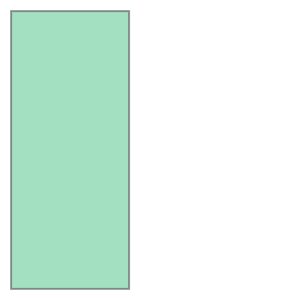

In [12]:
bbox

In [ ]:
def extract_raster_bounds(input_folder_path):
    """Function extracts raster bounds and returns a dictionary in EPSG: 3857"""
    bounds = {}
    for file in input_folder_path:
        if file.endswith(".tif") and "13" in file:
            raster = rxr.open_rasterio(file)
            reproj_raster = raster.rio.reproject(3857)
            bbox = reproj_raster.rio.bounds()
            bbox = box(bbox[0], bbox[3], bbox[2], bbox[1])
            dst.close()
            bounds[file] = bbox
    return bounds

In [13]:
dst = rxr.open_rasterio("Midland_DEM/USGS_13_n32w103_20211124.tif")

In [15]:
dst.rio.bounds()

(-11466093.33446702,
 3632538.3556523034,
 -11354401.940465253,
 3895525.0061658206)

In [21]:
raster = rxr.open_rasterio("Midland_DEM/USGS_13_n32w103_20211124.tif")
reproj_raster = raster.rio.reproject(3857)
bbox = reproj_raster.rio.bounds()

In [22]:
bbox

(-11465969.646769667,
 3632680.872677732,
 -11354521.345124174,
 3763383.5225764625)